# Diffusion

## Forward Diffusion Process:

$$x_{t} = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon \qquad \epsilon \sim N(0, I)$$

Variance preserving

$$x_{t-1} \sim N(0, I) \implies \text{Var}[x_t] = (1 - \beta_t) + \beta_t = 1$$

Sampling $x_t$ in a single step:

$$\text{Let } \alpha_t = 1 - \beta_t, \qquad \bar \alpha_t = \prod_{t=1}^T \alpha_t$$

$$
\begin{align*}

x_t &= \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon \\

&= \sqrt{1 - \beta_t} \left[ \sqrt{1 - \beta_{t-1}} x_{t-2} + \sqrt{\beta_{t-1}} \epsilon \right] + \sqrt{\beta_t} \epsilon \\

&= \sqrt{1 - \beta_t} \sqrt{1 - \beta_{t-1}} x_{t-2} + \sqrt{1 - \beta_t} \sqrt{\beta_{t-1}} \epsilon + \sqrt{\beta_t} \epsilon \\

&= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \epsilon \\

x_t &= \sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} \epsilon \\
\end{align*}
$$

## Reverse Diffusion Process:

Train a neural network that models:

$$p_\theta(x_{t-1} | x_t) = N(\mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \epsilon_\theta(x_t, t) \right)$$

$$\Sigma_\theta(x_t, t) = \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_t} \beta_t$$

Loss:

$$
\begin{align*}

L &= \mathbb{E} \left[ \frac{(1-\alpha_t)^2}{2 \alpha_t (1 - \bar \alpha_t) ||\Sigma_\theta||^2}
||\epsilon - \epsilon_\theta(\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} \epsilon, t)||^2 \right] \\ \\

L_\text{simple} &= \mathbb{E} \left[ ||\epsilon - \epsilon_\theta(\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} \epsilon, t)||^2 \right]

\end{align*}
$$

Sampling:

$$
\begin{align*}
& x_T \sim N(0, I) \\

& \text{for t in T..1}: \\
& \qquad \epsilon \sim N(0, I) \ \text{ if } t > 1 \ \text{ else } 0 \\
& \qquad x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t \epsilon \\ \\

\sigma_t^2 &= \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_t} \beta_t \qquad \text{or} \qquad \beta_t

\end{align*}
$$

Alternate interpretation of diffusion from Langevin Dynamics: diffusion models learn $\nabla_x \log p(x)$, the way the image should be perturbed (denoised) to make it match the data distribution.

What does the reweighted objective $L_\text{simple}$ change? First we must schedule $\beta_t$

## $\beta_t$ schedule

Desmos plots: https://www.desmos.com/calculator/74swzuyya5

$$\alpha_t = \text{max}(\frac{\bar \alpha_t}{\bar \alpha_{t-1}}, 0.001) \qquad \beta_t = 1 - \alpha_t$$

$$\bar \alpha_t = \frac{f(t)}{f(0)} \qquad f(t) = \cos^2 \left( \frac{t / T + s}{1 + s} \cdot \frac{\pi}{2} \right)$$

This noise schedule strongly prioritizes the low noise regime, very gradually increasing noise for a long time, and only adding a lot of noise only for $t$ very close to the $T$. This schedule makes the model spend less time denoising extremely noisy images, which doesn't matter as much as denoising coherent images.

So back to the important question: What does the reweighted objective $L_\text{simple}$ change?

The scaling term dropped by the reweighted objective is

$$\frac{(1-\alpha_t)^2}{2 \alpha_t (1 - \bar \alpha_t) ||\Sigma_\theta||^2}$$

This term is very very small until it blows up when $t$ gets close to $T$. By removing this weighting term, we are again decreasing the importance the model gives to denoising extremely noisy images and focusing the model on more meaningful denoising steps.

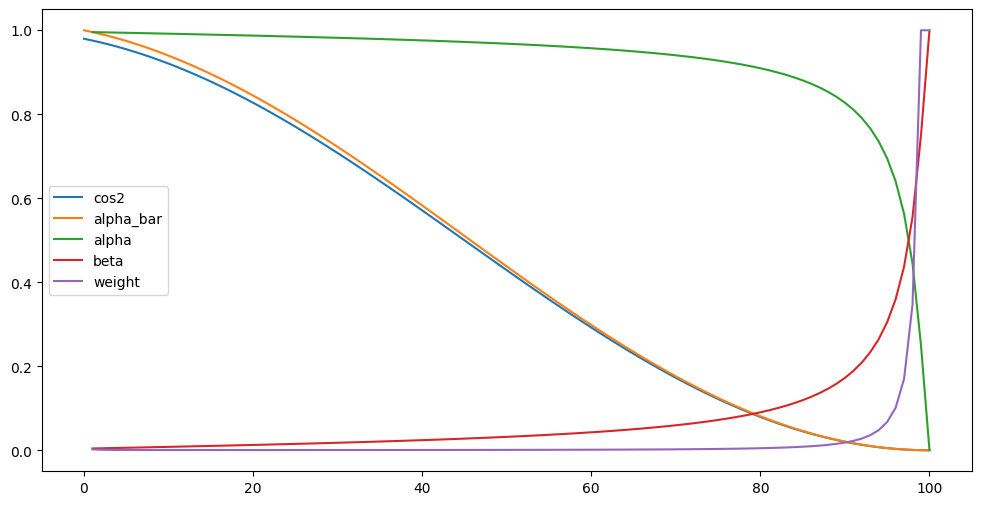

In [1]:
import torch
import matplotlib.pyplot as plt


def calc_cos_schedule(t: torch.Tensor, T: int, s: float = 0.1) -> torch.Tensor:
    phase = ((t / T) + s) / (1 + s)
    return torch.cos(phase * (torch.pi / 2.0)) ** 2.0

def calc_alpha_bar(t: torch.Tensor, T: int) -> torch.Tensor:
    return calc_cos_schedule(t, T) / calc_cos_schedule(torch.tensor(0.0, device=t.device), T)

def calc_alpha(alpha_bar: torch.Tensor) -> torch.Tensor:
    alpha = alpha_bar[1:] / alpha_bar[:-1]
    return alpha.maximum(torch.tensor(0.001, device=alpha_bar.device))


T = 100
t = torch.arange(T + 1)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, calc_cos_schedule(t, T), label="cos2")

alpha_bar = calc_alpha_bar(t, T)
ax.plot(t, alpha_bar, label="alpha_bar")

alpha = calc_alpha(alpha_bar)
ax.plot(t[1:], alpha, label="alpha")

ax.plot(t[1:], 1 - alpha, label="beta")

dropped_weight = ((1 - alpha) ** 2) / (2 * alpha * (1 - alpha_bar[1:]))
dropped_weight.clip_(max=1)
ax.plot(t[1:], dropped_weight, label="weight")

ax.legend()
plt.show()

torch.Size([60000, 1, 28, 28]) tensor(-1.) tensor(1.)


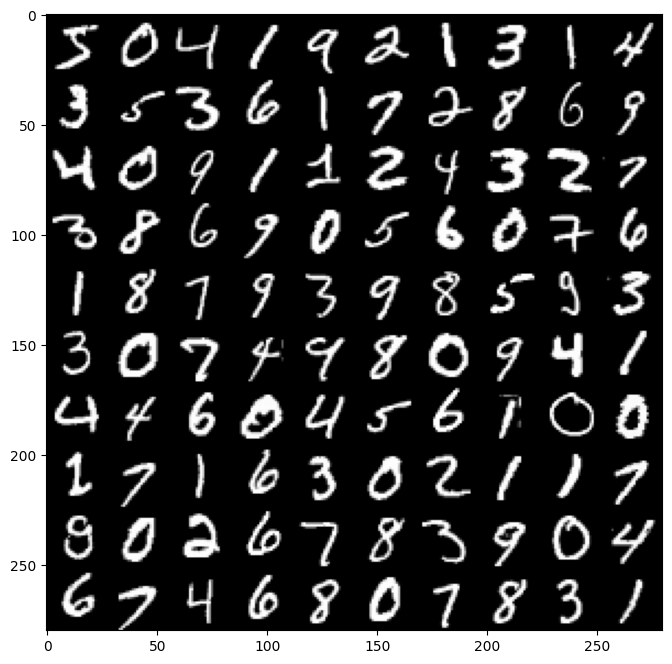

In [2]:
from torchvision.datasets import MNIST
from einops import rearrange


ds = MNIST(root="data", train=True, download=True)
images, labels = ds.data, ds.targets

images = images.to(dtype=torch.float32)
images = (images / (255 / 2)) - 1
images = images.unsqueeze(-3)
print(images.shape, images.min(), images.max())

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rearrange(images[:100], "(n b) c h w -> (n h) (b c w)", n=10), cmap="grey");
plt.show()

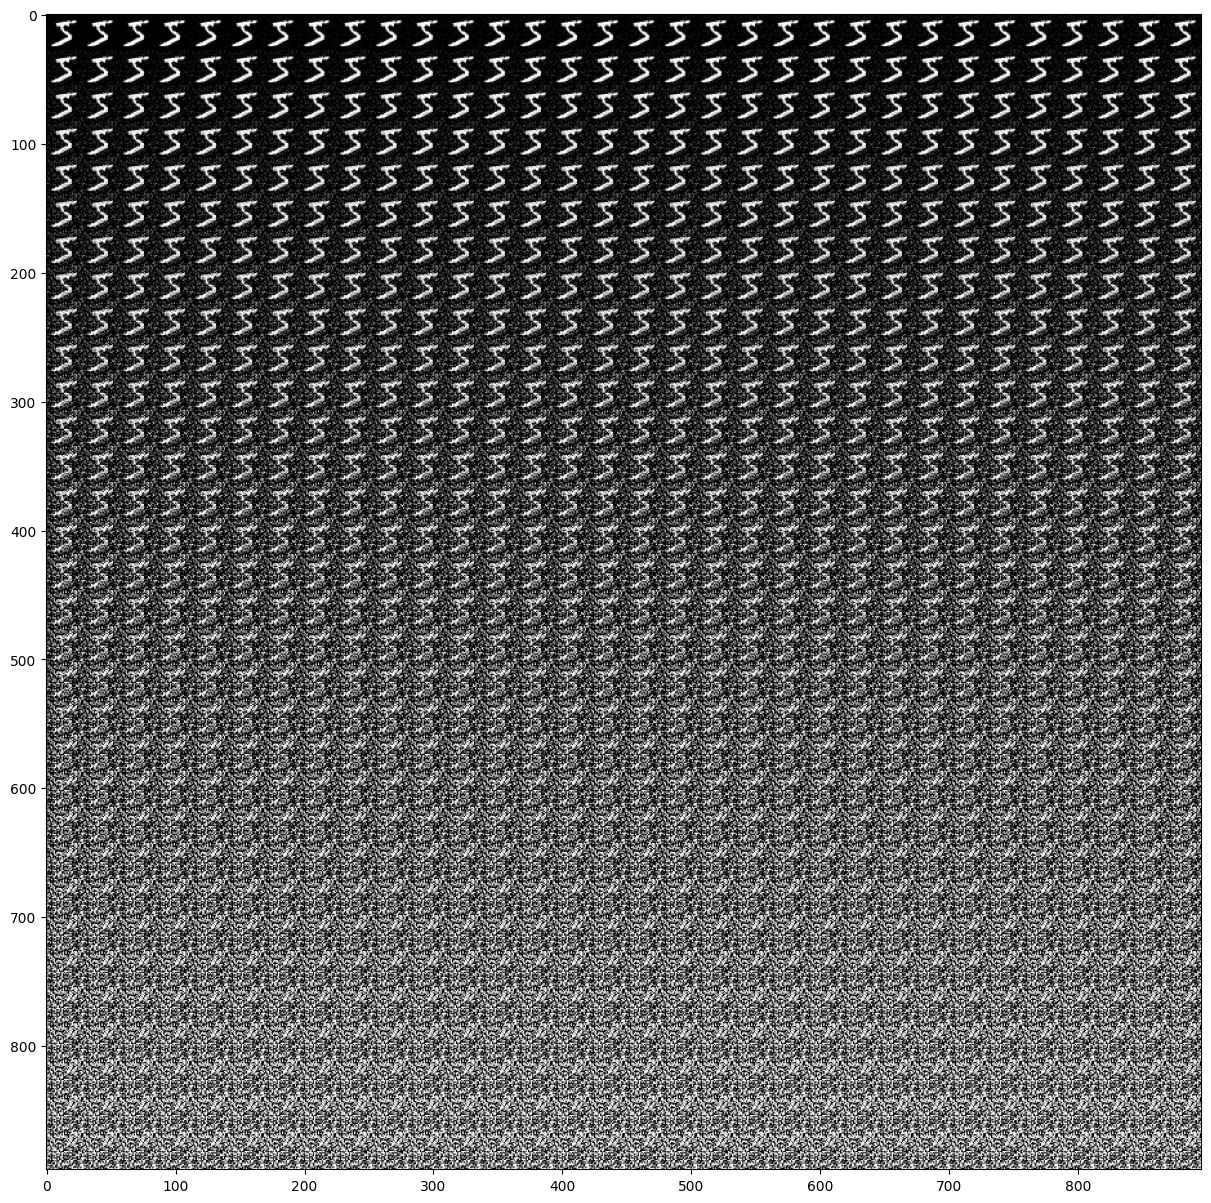

In [3]:
def add_noise(xs: torch.Tensor, t: torch.Tensor, T: int) -> tuple[torch.Tensor, torch.Tensor]:
    alpha_bar = calc_alpha_bar(t, T)
    alpha_bar = rearrange(alpha_bar, "b -> b 1 1 1")
    noise = (1 - alpha_bar).sqrt() * torch.randn_like(xs)
    return noise, (alpha_bar.sqrt() * xs) + noise


T = 1024
_, noised = add_noise(images[:1], torch.arange(T), T)
noised.clip_(-1, 1)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(rearrange(noised, "(n b) c h w -> (n h) (b c w)", n=32), cmap="grey");
plt.show()

## Model
* Unet: unmasked PixelCNN++
* self atten at 16x16 feature map
* cifar10 35.7M params

### Transfomer Positional Embedding

$$\text{PE}(\text{pos}, 2i) = \sin(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}})$$

$$\text{PE}(\text{pos}, 2i + 1) = \cos(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}})$$

$$i = 1 \dots \frac{d_{\text{model}}}{2} - 1$$

These are alternating sines and cosines (alternating in the emb dimension) over the position.

The sin/cos frequency is:

$$
\begin{align*}

\text{freq} &= \frac{1}{2 \pi} \cdot \frac{1}{10000^{2i / d_\text{model}}} \\ \\

i = 0: \qquad \text{freq} &= \frac{1}{2 \pi} \\

i = \frac{d_\text{model}}{2}: \qquad \text{freq} &= \frac{1}{2 \pi \cdot 10000}

\end{align*}
$$

Increasing the embedding dimension decreases the frequency of the sin/cos wave.

$\text{PE}(\text{pos} + k)$ is a linear comb of $\text{PE}(\text{pos})$ since:

$$
\begin{align*}

\sin(p + k) = \sin(p) \cos(k) + \cos(p) \sin(k) \\

\cos(p + k) = \cos(p) \cos(k) - \sin(p) \sin(k) \\

\end{align*}
$$

The longest period is

$$i = \frac{d_\text{model}}{2}: \qquad \text{period} = 2 \pi \cdot 10000 \approx 60,000$$

Assuming a max of $\sim 1000$ diffusion steps, this period is waaay too high. The sin/cos of the last embedding dim will barely move at the max diffusion steps, which is very wasteful because that makes it basically a constant.

If we have max of $T$ steps, and we want the last sin/cos to go fraction $C$ of a cycle, then $\frac{T}{C}$ is the maximum period we need, so we have

$$\sin(\frac{2 \pi \cdot p}{\frac{T}{C}})$$

$$10000 \implies \frac{1}{2 \pi} \cdot \frac{T}{C}$$

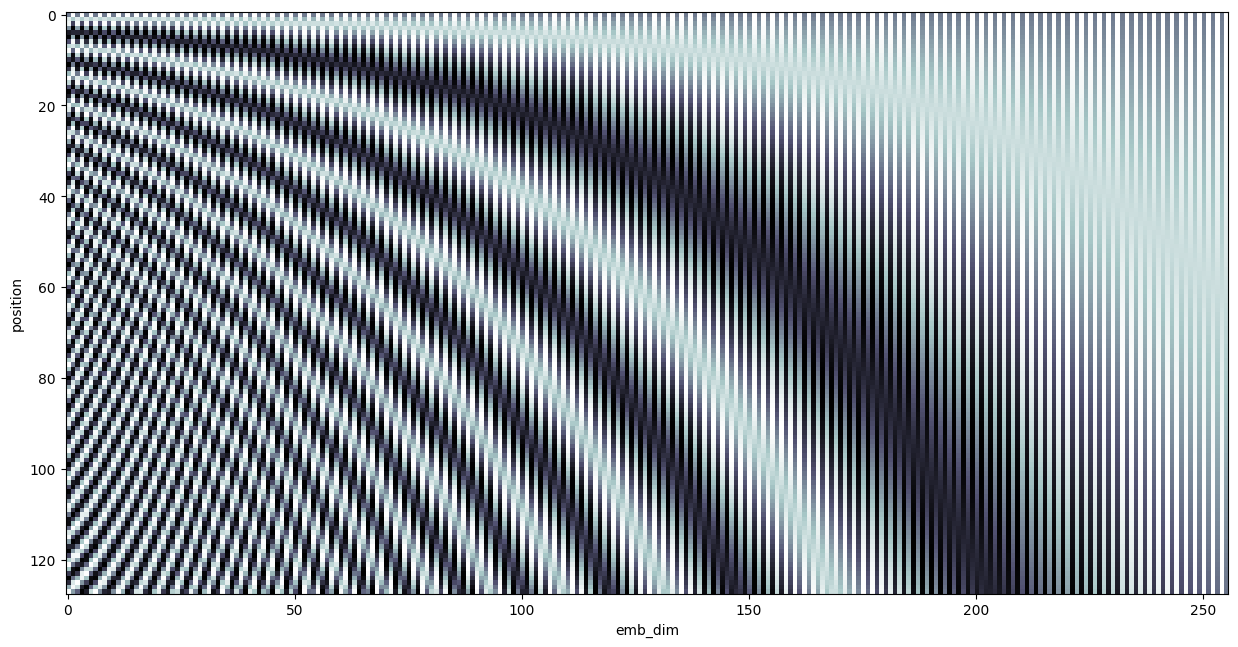

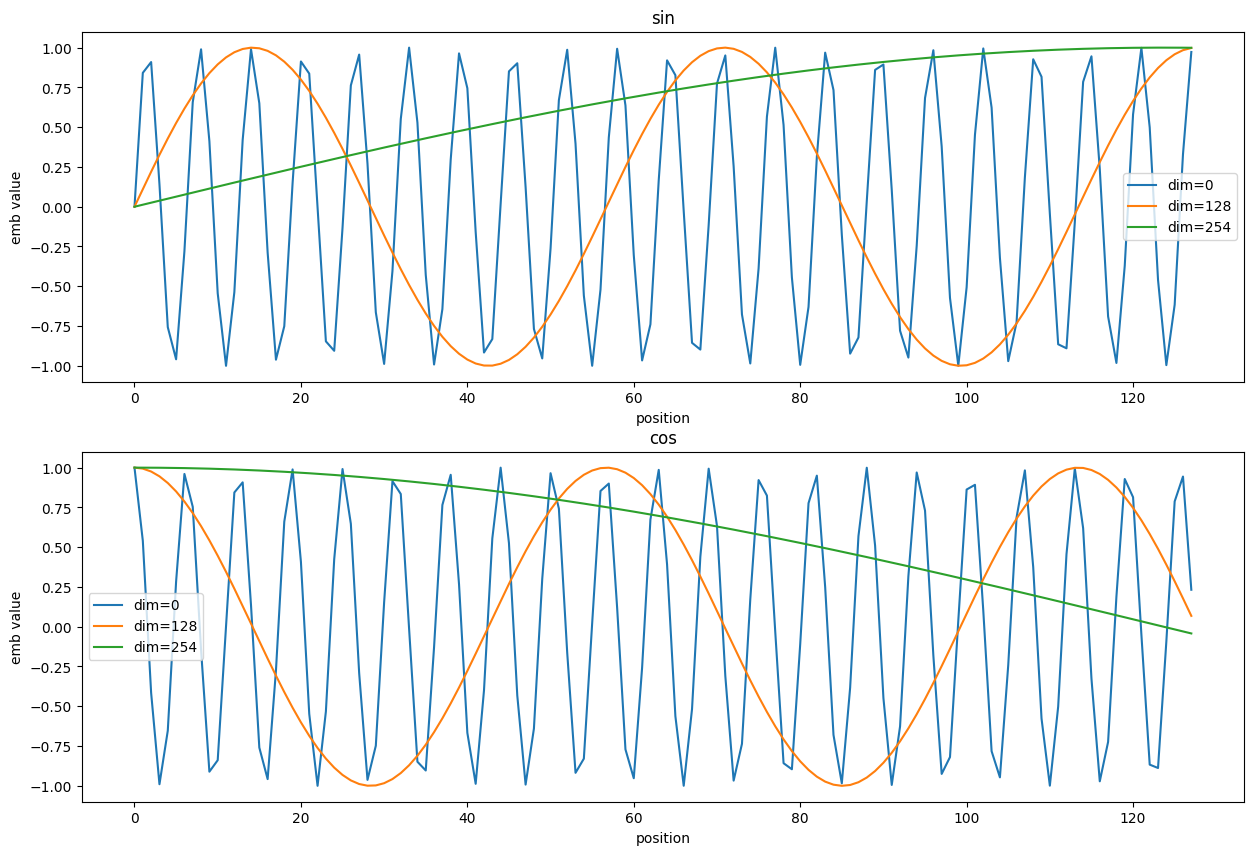

In [4]:
from torch import nn


class PosEnc(nn.Module):
    def __init__(self, max_pos: int, emb_dim: int):
        super().__init__()
        self.register_buffer("pos_enc", torch.empty((max_pos, emb_dim), dtype=torch.float32))
        pos = torch.arange(max_pos)

        # Slowest sin/cos makes it 0.25 of a full cycle.
        base = (max_pos / 0.25) / (2 * torch.pi)

        divs = base ** (2 * torch.arange(emb_dim // 2) / emb_dim)
        phase = pos[:, None] / divs
        self.pos_enc[pos, ::2] = phase.sin()
        self.pos_enc[pos, 1::2] = phase.cos()

    def forward(self, t: torch.Tensor):
        # t - 1 b/c t sampled from [1, T].
        return self.pos_enc[t - 1]


pos_enc = PosEnc(max_pos=128, emb_dim=256)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(pos_enc.pos_enc, cmap="bone")
ax.set_ylabel("position")
ax.set_xlabel("emb_dim")
plt.show()

fig, (sin_ax, cos_ax) = plt.subplots(nrows=2, figsize=(15, 10))
for i in [0, 128, 254]:
    sin_ax.plot(pos_enc.pos_enc[:, i], label=f"dim={i}")
    cos_ax.plot(pos_enc.pos_enc[:, i+1], label=f"dim={i}")

sin_ax.set_title("sin")
sin_ax.set_xlabel("position")
sin_ax.set_ylabel("emb value")
sin_ax.legend(loc=0)

cos_ax.set_title("cos")
cos_ax.set_xlabel("position")
cos_ax.set_ylabel("emb value")
cos_ax.legend(loc=0)

plt.show()

### BatchNorm vs GroupNorm
Diffusion models use GroupNorm and not BatchNorm. Why?

BatchNorm normalizes each channel dimension.

A channel is the output of a conv filter applied to an image. So you could imagine if you had 2 channels (feature maps), one from a vertical edge conv filter and another from a horizontal edge conv filter, normalizing over the channel dimension would mean making each feature map zero mean and unit variance, and then scaling and biasing.

For a conv feature map of shape (B, C, H, W), means and variances are calculated over (B, H, W). So if BatchNorm was applied to a batch of RGB images, BatchNorm would calculate a mean and variance for each color channel, and each color channel would be independently normalized. The insane and evil thing about BatchNorm is that **a normalized sample depends on all other samples in the batch**.

In diffusion training, the model is given images at various stages of the forward diffusion process, and must predict the added noise. So images in single a batch will have wildly different levels of noise. A BatchNorm inside a diffusion model would be calculating the feature map mean and variance over very clean images and very noisy ones, which doesn't make much sense, since why should the feature map distribution for clean and noisy images be the same?

GroupNorm normalizes each groups of channels, seperately for each batch. This removes the evil BatchNorm dependence across all samples in the batch.

GroupNorm with $|G| = C$ is InstanceNorm, and GroupNorm with $|G| = 1$ is LayerNorm.

In [5]:
class ConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int,
        time_emb_dim: int, group_size: int,
        max_pool: bool = False, upsample: bool = False
    ):
        super().__init__()
        assert not (max_pool and upsample), "Cannot max pool and upsample."

        conv_out_channels = out_channels * 2 if upsample else out_channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, conv_out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(conv_out_channels // group_size, conv_out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(conv_out_channels, conv_out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(conv_out_channels // group_size, conv_out_channels),
            nn.ReLU()
        )

        self.time_proj = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.GELU(),
            nn.Linear(time_emb_dim * 4, conv_out_channels)
        )

        if in_channels == conv_out_channels:
            self.passthrough = nn.Identity()
        else:
            self.passthrough = nn.Conv2d(in_channels, conv_out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.post = nn.Identity()
        if max_pool:
            self.post = nn.MaxPool2d(2, 2)
        elif upsample:
            self.post = nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(conv_out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.GroupNorm(out_channels // group_size, out_channels),
                nn.ReLU()
            )

    def forward(self, xb: torch.Tensor, time_emb: torch.Tensor):
        z = self.conv1(xb)
        time_emb = rearrange(self.time_proj(time_emb), "b c -> b c 1 1")
        z = self.conv2(z + time_emb)
        z = z + self.passthrough(xb)
        post = self.post(z)
        return (z, post)


class UNet(nn.Module):
    def __init__(self, image_channels: int, conv_channels: int, max_time: int, time_emb_dim: int, group_size: int):
        super().__init__()
        self.down_conv1 = ConvBlock(image_channels, conv_channels, time_emb_dim, group_size, max_pool=True)
        self.down_conv2 = ConvBlock(conv_channels, conv_channels * 2, time_emb_dim, group_size, max_pool=True)

        self.bottleneck = ConvBlock(conv_channels * 2, conv_channels * 4, time_emb_dim, group_size)

        self.up_conv1 = ConvBlock(conv_channels * 4, conv_channels * 2, time_emb_dim, group_size, upsample=True)
        self.up_conv2 = ConvBlock(conv_channels * 4, conv_channels, time_emb_dim, group_size, upsample=True)

        self.out_conv = ConvBlock(conv_channels * 2, conv_channels * 2, time_emb_dim, group_size)
        self.to_pix = nn.Conv2d(conv_channels * 2, image_channels, kernel_size=3, stride=1, padding=1, bias=True)

        self.time_embedding = nn.Sequential(
            PosEnc(max_time, time_emb_dim),
            # nn.Linear(time_emb_dim, time_emb_dim * 4),
            # nn.GELU(),
            # nn.Linear(time_emb_dim * 4, time_emb_dim),
            # nn.GELU(),
        )

    def forward(self, xb: torch.Tensor, t: torch.Tensor):
        time_emb = self.time_embedding(t)
        res1, down1 = self.down_conv1(xb, time_emb)
        res2, down2 = self.down_conv2(down1, time_emb)
        _, z = self.bottleneck(down2, time_emb)
        _, up2 = self.up_conv1(z, time_emb)
        _, up1 = self.up_conv2(torch.cat((up2, res2), dim=1), time_emb)
        _, pre_out = self.out_conv(torch.cat((up1, res1), dim=1), time_emb)
        out = self.to_pix(pre_out)
        return out

In [6]:
import wandb
from torch.optim import Adam


@torch.no_grad()
def sample_diffusion(model: nn.Module, batch_size: int, image_shape: tuple[int, int, int], max_diffusion_steps: int) -> torch.Tensor:
    batched_shape = (batch_size, *image_shape)
    device = next(model.parameters()).device
    x = torch.randn(batched_shape, dtype=torch.float32, device=device)

    times = torch.arange(max_diffusion_steps + 1, device=device)
    alpha_bar = calc_alpha_bar(times, max_diffusion_steps)
    alpha = calc_alpha(alpha_bar)

    for t in range(max_diffusion_steps, 0, -1):
        time = times[t].expand(batch_size)
        pred_noise = ((1 - alpha[t-1]) / (1 - alpha_bar[t]).sqrt()) * model(x, time)
        x = (x - pred_noise) / alpha[t-1].sqrt()

        if t > 1:
            # noise_scale = (1 - alpha_bar[t-1]) * (1 - alpha[t-1]) / (1 - alpha_bar[t])
            noise_scale = 1 - alpha[t-1]
            noise = torch.randn(batched_shape, dtype=torch.float32, device=device) * noise_scale.sqrt()
            x = x + noise
    return x


MAX_DIFFUSION_STEPS = 1024
TIME_EMB_DIM = 32
GROUP_SIZE = 4
CONV_CHANNELS = 32
N_STEPS = 32_000
LR = 1e-4
BATCH_SIZE = 64

model = UNet(images.shape[1], CONV_CHANNELS, MAX_DIFFUSION_STEPS, TIME_EMB_DIM, GROUP_SIZE).to("cuda")
optim = Adam(model.parameters(), lr=LR)

run = wandb.init(
    project="ddpm",
    config={"max_diffusion_steps": MAX_DIFFUSION_STEPS, "time_emb_dim": TIME_EMB_DIM, "group_size": GROUP_SIZE,
            "lr": LR, "n_epochs": N_STEPS, "batch_size": BATCH_SIZE}
)

images = images.to("cuda")
for step in range(N_STEPS):
    xb = images[torch.randint(len(images), (BATCH_SIZE,), device="cuda")]

    t = torch.randint(1, MAX_DIFFUSION_STEPS + 1, (BATCH_SIZE,), device="cuda")
    noise, xb_noised = add_noise(xb, t, MAX_DIFFUSION_STEPS)

    pred_noise = model(xb_noised, t)

    loss = ((noise - pred_noise) ** 2).sum() / BATCH_SIZE
    optim.zero_grad()
    loss.backward()
    optim.step()

    if (step % 500) == 0:
        print(f"{str(step):<5}: {loss.item():.3f}")
        run.log({"loss": loss.item()}, step=step)
        
        if (step % 1000) == 0:
            samples = sample_diffusion(model, batch_size=16, image_shape=xb[0].shape, max_diffusion_steps=MAX_DIFFUSION_STEPS).cpu()

            # TODO: the range of sampled points looks wrong.
            density, bins = samples.histogram(bins=50)
            plt.plot((bins[1:] + bins[:-1]) / 2, density)

            samples = rearrange(samples , "(row col) c h w -> c (row h) (col w)", row=4, col=4)
            samples = ((samples.clip(-1, 1) + 1) * (255 / 2)).to(dtype=torch.uint8)
            run.log({"samples": wandb.Image(samples), "sample_hist": plt}, step=step)

run.finish()

wandb: Currently logged in as: gbc24001 (gbc24001-university-of-connecticut) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


0    : 849.883
500  : 18.720
1000 : 13.125
1500 : 13.264
2000 : 12.621
2500 : 9.306
3000 : 9.674
3500 : 10.478
4000 : 11.353
4500 : 8.000
5000 : 9.627
5500 : 8.989
6000 : 9.523
6500 : 9.417
7000 : 10.328
7500 : 9.386
8000 : 9.954
8500 : 9.298
9000 : 8.940
9500 : 8.843
10000: 9.018
10500: 8.605
11000: 8.358
11500: 9.528
12000: 10.345
12500: 8.488
13000: 8.830
13500: 8.626
14000: 8.118
14500: 9.698
15000: 9.646
15500: 8.087
16000: 8.005
16500: 7.353
17000: 7.368
17500: 9.374
18000: 7.762
18500: 8.691
19000: 8.409
19500: 8.455
20000: 8.369
20500: 8.135
21000: 9.034
21500: 6.779
22000: 8.439
22500: 8.510
23000: 7.032
23500: 7.848
24000: 8.495
24500: 9.593
25000: 8.734
25500: 8.365
26000: 8.251
26500: 7.496
27000: 8.378
27500: 8.657
28000: 9.117
28500: 7.695
29000: 8.453
29500: 7.489
30000: 7.276
30500: 8.797
31000: 7.547
31500: 8.155
